<a href="https://colab.research.google.com/github/sarahatami/Unsupervised-Drivable-Area-Detection/blob/master/Fully_Unsupervised_Road_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os
import numpy as np
from os import listdir
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import torchvision
import torchvision.models.segmentation as seg
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import sys
from collections import namedtuple
from PIL import Image
from PIL import ImageDraw
import torch.nn.functional as F
from google.colab import drive
from numpy.linalg import norm
import math
import datetime
from torch import nn
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, deeplabv3_resnet50, lraspp_mobilenet_v3_large

torch.set_printoptions(threshold=10000)
np.set_printoptions(threshold = np.inf)

Dataset for Train


In [ ]:
! wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=sarahatami&password=Ab@1234567890&submit=Login' https://www.cityscapes-dataset.com/login/
! wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=12 #sequence

In [ ]:
!unzip /content/leftImg8bit_demoVideo.zip

In [4]:
!cp /content/leftImg8bit/demoVideo/stuttgart_00/stuttgart_00_000000_000599_leftImg8bit.png /content/leftImg8bit/demoVideo/stuttgart_00/stuttgart_00_000000_000600_leftImg8bit.png

In [5]:
def count_images(directory, extension):
    return len([entry for entry in os.scandir(directory) if entry.is_file() and entry.name.endswith(extension)])
directory = '/content/leftImg8bit/demoVideo/stuttgart_00'
extension = '.png'
count_images(directory, extension)

600

Preparing Data

In [6]:
transform = transforms.Compose([transforms.Resize((205, 410)),
                                transforms.ToTensor()])

In [7]:
### Defining the Dataset class ###
class CityscapesTrain(Dataset):
    def __init__(self, transform=None, img_dir=None):
        self.transform = transform
        self.images_dir = img_dir
        self.images = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        pil_image = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(pil_image)
        return img

In [32]:
#Define Dataloader
train_addr_img='/content/leftImg8bit/demoVideo/stuttgart_00'
trainset = CityscapesTrain(transform=transform, img_dir=train_addr_img)
batch_size = 6
dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

TEST

HORIZON

In [9]:
teta = 0.457
horizon = int( 1354.98 - (2305.87 * math.tan(teta)) )
horizon=90

4 Point Coordinates

In [10]:
H = [[137.122	, -282.815  ,  0],
     [64.142	,   0      , 345.458],
     [1       ,   0      ,  0]]
# Points are on the ground --> z=0
world_point1= [2.6 ,0.7 ,1]
world_point2= [2.6 ,-2 ,1]
world_point3= [4 ,0.2 ,1]
world_point4= [4 ,-2 ,1]

u_v_w1= np.dot(H , world_point1)
u1,v1= u_v_w1[0]/u_v_w1[2],u_v_w1[1]/u_v_w1[2]
u1,v1=int(u1), int(v1)

u_v_w2= np.dot(H , world_point2)
u2,v2= u_v_w2[0]/u_v_w2[2],u_v_w2[1]/u_v_w2[2]
u2,v2=int(u2), int(v2)

u_v_w3= np.dot(H , world_point3)
u3,v3= u_v_w3[0]/u_v_w3[2],u_v_w3[1]/u_v_w3[2]
u3,v3=int(u3), int(v3)

u_v_w4= np.dot(H , world_point4)
u4,v4= u_v_w4[0]/u_v_w4[2],u_v_w4[1]/u_v_w4[2]
u4,v4=int(u4), int(v4)

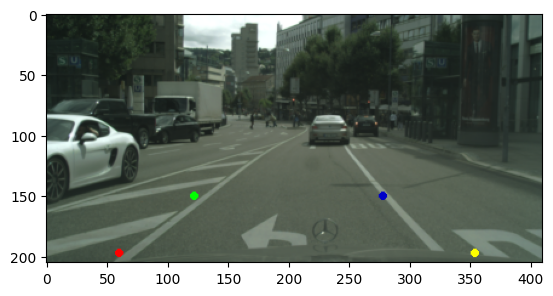

NameError: name 'stop' is not defined

In [ ]:
folder_dir='/content/leftImg8bit/demoVideo/stuttgart_00'
s = 3
for image in sorted(os.listdir(folder_dir)):
  input_path = os.path.join(folder_dir, image)
  im = Image.open(input_path).convert("RGB") #<class 'PIL.Image.Image'>
  im = transforms.Resize((205, 410))(im)

  canvas = ImageDraw.Draw(im)
  canvas.ellipse((u1-s, v1-s, u1+s, v1+s), fill=(255, 0, 0))
  canvas.ellipse((u2-s, v2-s, u2+s, v2+s), fill=(255, 255, 0))
  canvas.ellipse((u3-s, v3-s, u3+s, v3+s), fill=(0, 255, 0))
  canvas.ellipse((u4-s, v4-s, u4+s, v4+s), fill=(0, 0, 200))
  del canvas

  plt.imshow(im)
  plt.show()

ROAD MASK

In [11]:
def create_road_mask(img: torch.tensor) -> torch.tensor:
  img = img.cpu().detach().numpy()
  h = img.shape[0]
  w = img.shape[1]
  label_map = np.zeros((h,w), dtype=np.uint8)

  points = np.array([[u1, v1], [u3, v3], [u4, v4], [u2, v2]])
  label_map = cv2.fillPoly(label_map, pts=[points], color=(1, 0, 0))

  label_map = torch.from_numpy(label_map)
  return label_map

Weight Map

In [12]:
#CREATE WEIGHT MASK
def create_weight_mask(img: torch.tensor) -> torch.tensor:
  img = img.cpu().detach().numpy()
  h = img.shape[0]
  w = img.shape[1]
  weight_map = np.zeros((h,w), dtype=np.uint8)

  horizon_points = np.array([[0,0], [0, horizon], [w, horizon], [w, 0]])
  weight_map = cv2.fillPoly(weight_map, pts=[horizon_points], color=(1, 0, 0))

  road_points = np.array([[u1, v1], [u3, v3], [u4, v4], [u2, v2]])
  weight_map = cv2.fillPoly(weight_map, pts=[road_points], color=(1, 0, 0))

  weight_map = torch.from_numpy(weight_map)
  return weight_map

Road and Horizon Loss

In [13]:
bce_loss = nn.BCELoss(reduction='none')
class RoadHorizonLoss(nn.Module):
    def __init__(self):
        super(RoadHorizonLoss, self).__init__()
    def forward(self, outputs:torch.tensor):
        targets = [create_road_mask(outputs[i]).to(device).float() for i in range(batch_size)]
        road_losses = bce_loss(outputs, torch.stack(targets, dim=0))
        weighted_sum_losses = [road_losses[i] * (create_weight_mask(road_losses[i]).to(device)) for i in range(batch_size)]
        loss = torch.mean(torch.stack(weighted_sum_losses, dim=0))
        return loss

TRAIN

In [14]:
num_epochs = 100
learning_rate = 1e-3
criterion = RoadHorizonLoss()
num_classes=2

# params for ShiTomasi corner detection
feature_params = dict(maxCorners=2000,
                      qualityLevel=0.001,
                      minDistance=5,
                      blockSize=5)

# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(35, 35),
                 maxLevel=1,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.01))

color = np.random.randint(0, 255, (1000, 3))

In [29]:
def track(img1,img2):
    img1 = np.asarray(np.transpose(img1.cpu(), (1, 2, 0)))
    img2 = np.asarray(np.transpose(img2.cpu(), (1, 2, 0)))

    old_frame = np.ascontiguousarray(img1*255, dtype=np.uint8)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

    frame = np.ascontiguousarray(img2*255, dtype=np.uint8)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    if p1 is not None: # Select good points being successfully tracked
        good_new = p1[(st == 1) & (err < 20)]
        good_old = p0[(st == 1) & (err < 20)]

    h, w =205, 410
    label_map = np.zeros((h, w), dtype=np.uint8)
    points = np.array([[u1, v1], [u3, v3], [u4, v4], [u2, v2]])
    label_map = cv2.fillPoly(label_map, pts=[points], color=(1, 0, 0))
    new_points = []
    old_points = []
    all_errors = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        if b<205 and a<410 and d<205 and c<410 :
            if (label_map[int(b), int(a)] == 1.0 and label_map[int(d), int(c)] == 1.0) or (b<horizon and d<horizon) or\
             a<0 or b<0 or c<0 or d<0:
              continue
        if b>205 or a>410 or d>205 or c>410 :
              continue

        new_points.append((int(b), int(a)))
        old_points.append((int(d), int(c)))

        good_errors = err[st == 1]
        all_errors.extend(good_errors.flatten())

    # print(f"Error Range: {np.min(all_errors)} to {np.max(all_errors)}")

    return old_points, new_points

Show The Track


In [16]:
def initial_mask(img: torch.tensor): #displays road and horizon mask
  h,w = 205, 410
  label_map = np.zeros((h,w), dtype=np.uint8)
  color_map = np.zeros((h,w,3), dtype=np.uint8)

  points = np.array([[u1, v1], [u3, v3], [u4, v4], [u2, v2]])
  label_map = cv2.fillPoly(label_map, pts=[points], color=(1, 0, 0))

  horizon_points = np.array([[0,0], [0, horizon], [w, horizon], [w, 0]])
  label_map = cv2.fillPoly(label_map, pts=[horizon_points], color=(1, 0, 0))

  color_map = np.where(label_map[:,:,None] == 1, (0,153,0), (0,0,0))
  return color_map

SHOW

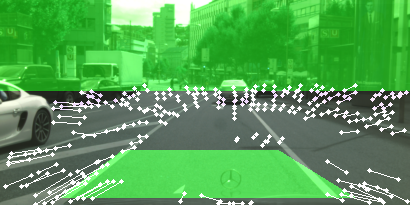

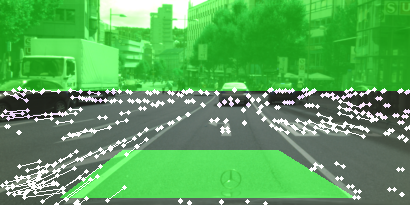

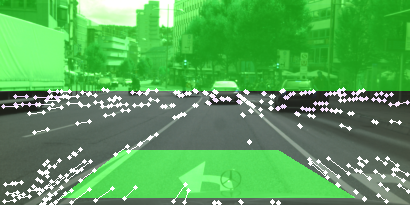

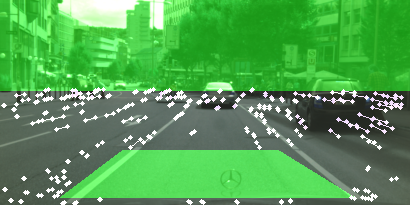

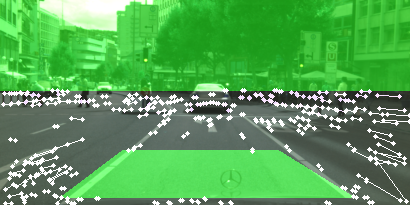

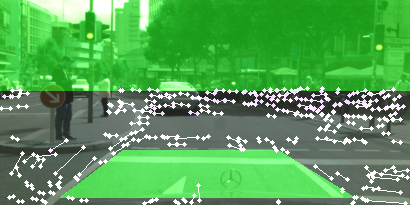

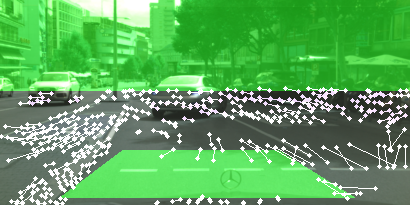

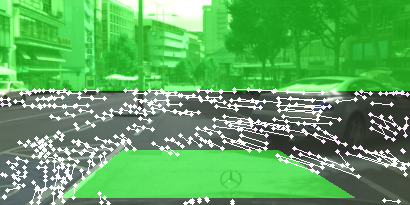

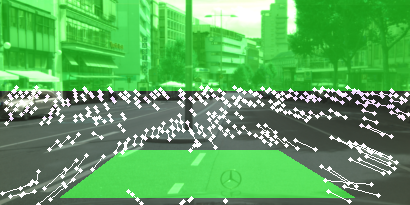

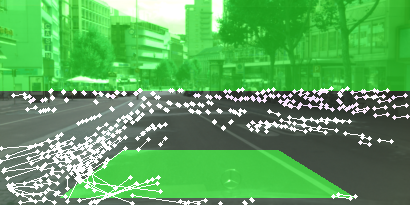

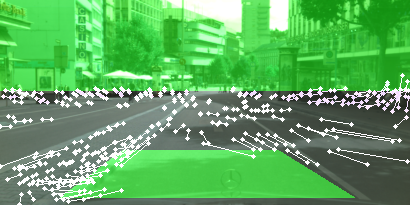

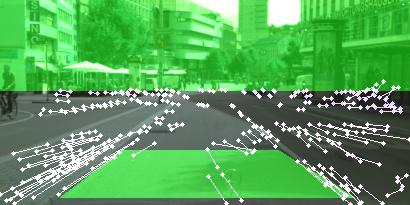

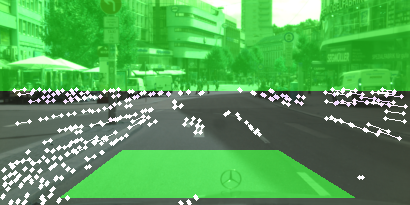

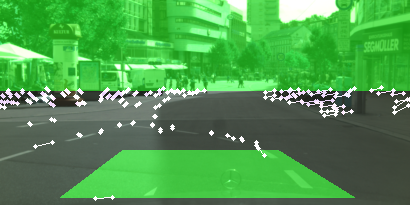

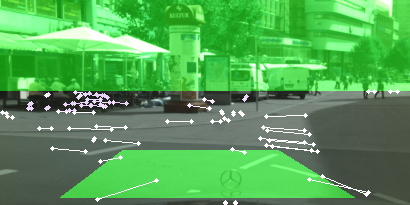

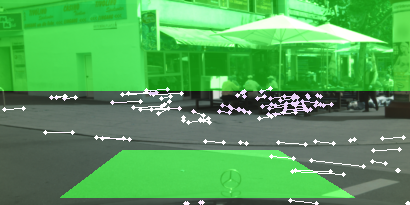

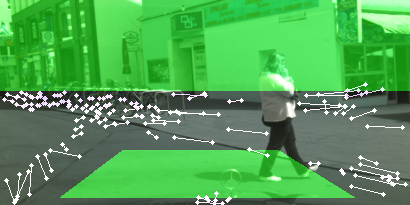

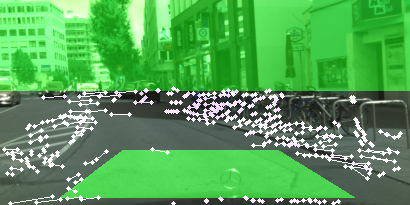

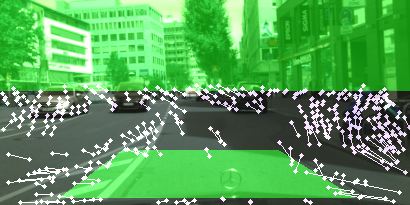

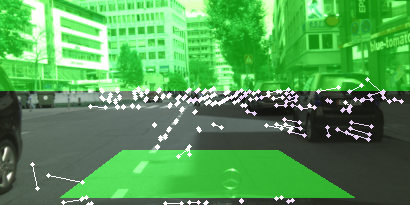

In [45]:
for ind, images in enumerate(dataloader_train):
  lists = track(images[0],images[batch_size-1])
  mask = np.zeros((205, 410, 3)).astype(np.uint8)
  for old, new in zip(lists[0], lists[1]):
    old=(old[1], old[0])
    new=(new[1], new[0])
    colour = color[i].tolist()
    cv2.line(mask[0:339, 0:423], new, old, colour, 1)
    cv2.circle(mask[0:339, 0:423], new, 2, colour, -1)
    cv2.circle(mask[0:339, 0:423], old, 2, colour, -1)

  # Add track mask and rgb labels to image for showing
  image = images[batch_size-1,:,:,:]
  J = image.cpu().numpy()
  J = np.transpose(J, (1, 2, 0))
  J = np.ascontiguousarray(J*255, dtype=np.uint8)
  J = cv2.add(J, mask)

  mask2 = initial_mask(image)

  J = J + (0.8* mask2.astype('float32'))
  if ind%5 == 0:
    cv2_imshow(J)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = seg.lraspp_mobilenet_v3_large(pretrained=False)
model.classifier.high_classifier = torch.nn.Conv2d(model.classifier.high_classifier.in_channels
                                                   , num_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.low_classifier = torch.nn.Conv2d(model.classifier.low_classifier.in_channels
                                                   , num_classes, kernel_size=(1, 1), stride=(1, 1))
model_path="/content/300.torch"
model.load_state_dict(torch.load(model_path))
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

Training using Mutual Information

In [ ]:
#Invariant Information Clustering
EPS = 1e-6
def IIC(z, zt, C=2):
    P = (z.unsqueeze(2) * zt.unsqueeze(1)).sum(dim=0)
    P = ((P + P.t()) / 2) / P.sum()
    P[(P < EPS).data] = EPS
    Pi = P.sum(dim=1).view(C, 1).expand(C, C)
    Pj = P.sum(dim=0).view(1, C).expand(C, C)
    return (P * (torch.log(Pi) + torch.log(Pj) - torch.log(P))).sum()

In [ ]:
#Train Loop
model.train()
t1 = datetime.datetime.now()
loss_list=[]
for i, data in enumerate(dataloader_train):
    globals()[f"first_coord_{i}"]=[]
    globals()[f"sec_coord_{i}"]=[]

for epoch in range(10):
    for i, data in enumerate(dataloader_train):
        inputs = data.to(device)
        outputs = model(inputs)['out']
        pred_probab = F.softmax(outputs.float())
        pred_lable_one = pred_probab[:, 1 ,:,:]

        loss1 = criterion(pred_lable_one)

        ###Paired Loss Calculation###
        image1, image2 = inputs[0,:,:,:], inputs[batch_size-1,:,:,:]
        coordinates = track(image1, image2)

        globals()[f"first_coord_{i}"].extend(coordinates[0])
        globals()[f"sec_coord_{i}"].extend(coordinates[1])

        pred1, pred2 = pred_probab[0,:,:,:], pred_probab[batch_size-1,:,:,:]

        points1_value = [pred1[:,j[0],j[1]].tolist() for j in globals()[f"first_coord_{i}"]]
        points2_value = [pred2[:,k[0],k[1]].tolist() for k in globals()[f"sec_coord_{i}"]]

        points1_value = torch.tensor(points1_value, requires_grad=True).to(device)
        points2_value = torch.tensor(points2_value, requires_grad=True).to(device)

        loss2 = IIC(points1_value, points2_value) #MI
        loss = loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(loss.item())

    if epoch % 10 == 0:
      t2 = datetime.datetime.now()
      torch.save(model.state_dict(), f"{300+epoch}.torch")
      print(f"epoch {epoch}, step {i}, loss1: {loss1.item()}, loss2: {loss2.item()}, time: {t2}")

torch.save(model.state_dict(), f"{300+epoch}.torch")
print(f"elapsed time (m): {(t2 - t1).seconds/60}") # 300epochs in total

In [ ]:
# !find . -name "*2nd.torch" -type f -delete

TEST

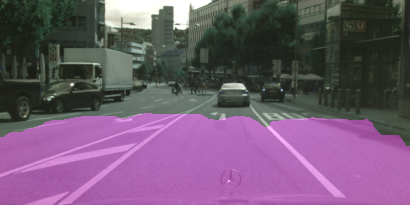

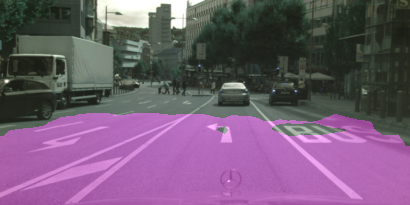

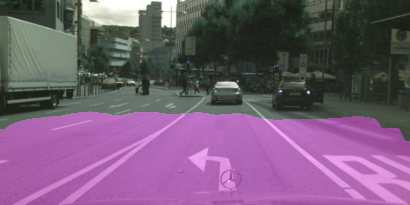

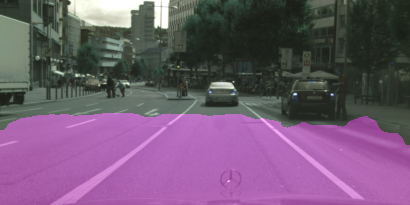

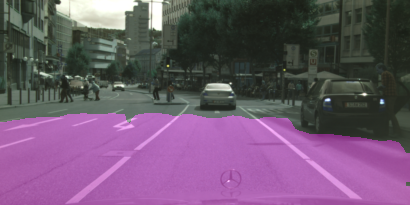

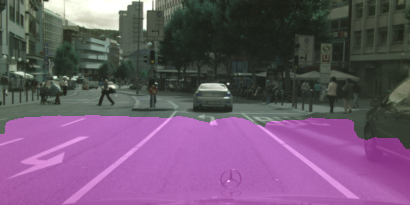

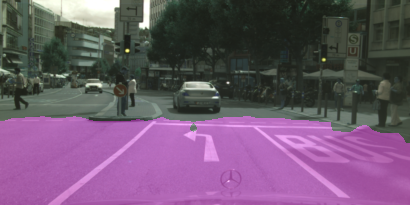

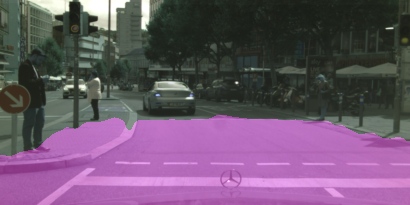

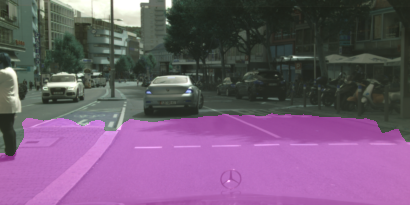

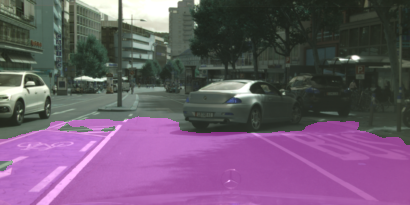

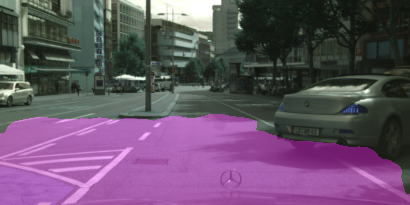

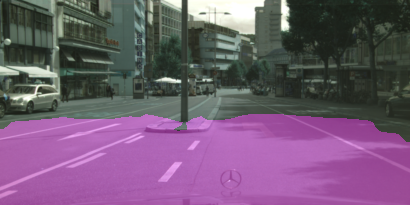

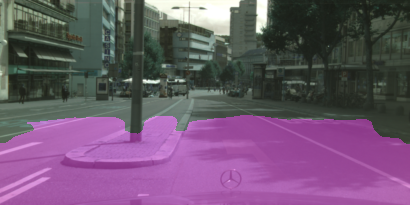

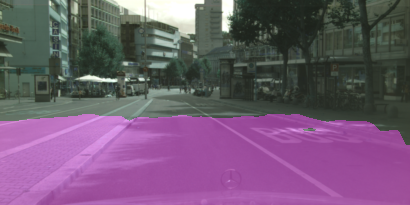

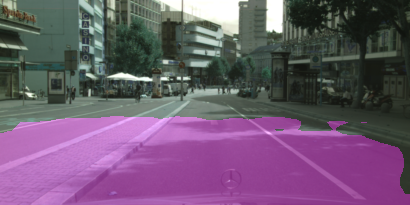

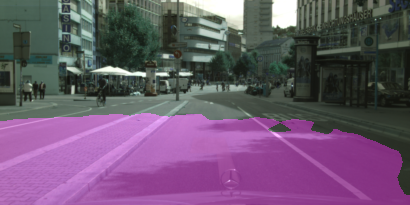

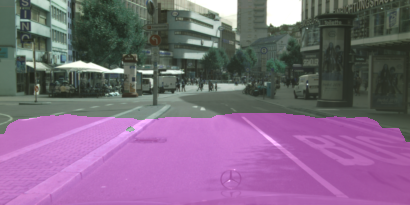

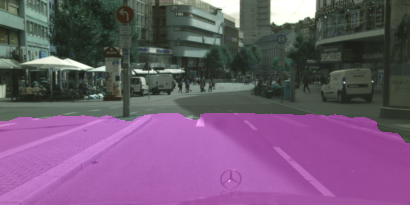

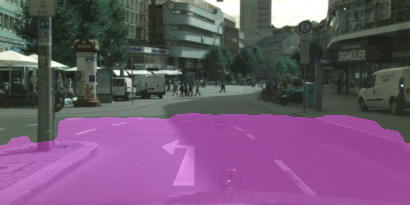

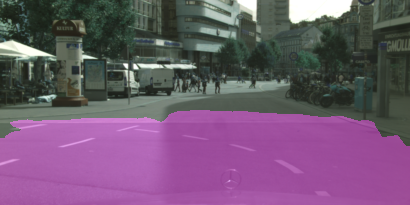

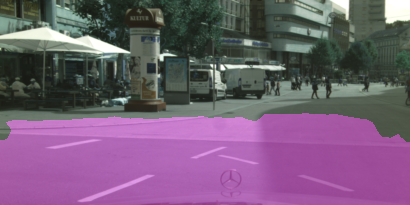

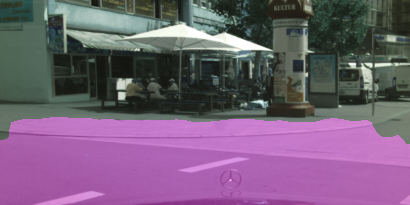

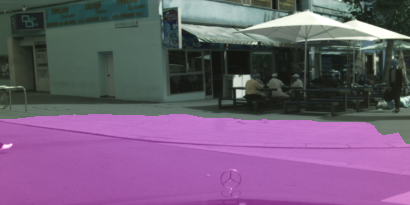

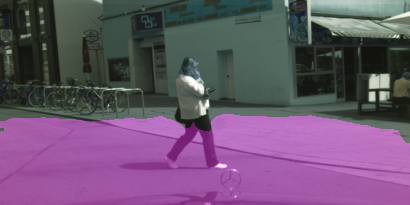

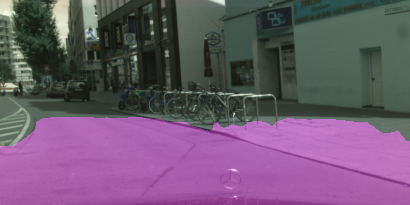

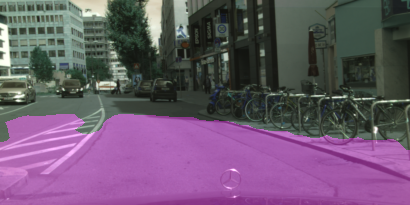

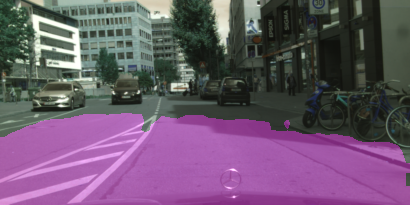

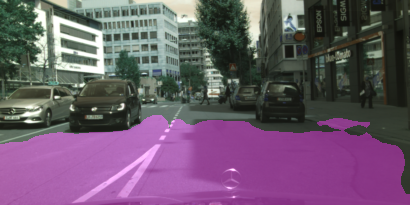

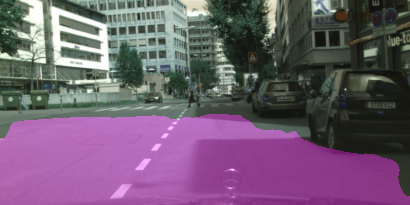

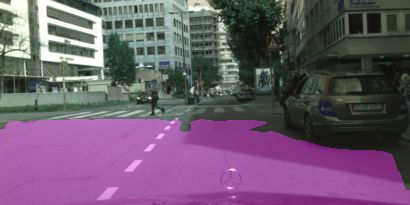

In [20]:
model.eval()
color_map = [(  0,  0,  0) , (128, 0, 128) ]
for ind, data in enumerate(dataloader_train):
  images = data
  images = images.to(device)
  outputs = model(images)['out']
  segm = torch.argmax(outputs, 1).cpu().detach().numpy()
  labelmap=segm[batch_size-1,:,:]

  # create rgb lable map
  rgblabel = np.zeros((3, 205, 410), dtype=np.uint8)
  for i in range(labelmap.shape[0]):
    for j in range(labelmap.shape[1]):
        color_index = labelmap[i, j]
        rgblabel[:, i, j] = color_map[color_index]

  image = images[batch_size-1,:,:,:]
  J = image.cpu().numpy()
  J = np.transpose(J, (1, 2, 0))
  J = np.ascontiguousarray(J*255, dtype=np.uint8)

  J = J  +  0.7* np.transpose(rgblabel.astype('float32'), (1, 2, 0))
  cv2_imshow(J)